In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

# Coloring to preserve Computational Details:
[OpenCV python tutorials](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html) <br>
[OpenCV miscellaneous transformations](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html) <br>
[OpenCV Index](https://docs.opencv.org/2.4/genindex.html) <br>


In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
import sys
import tempfile

import cv2
import skimage.io as im_io
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

from PIL import TiffImagePlugin as tip
from PIL.TiffImagePlugin import Image
from PIL import ImageOps

sys.path.insert(0, '../src/')
sys.path.insert(0, 'scalygraphic/src/')

from im_scale_products import *
from impute_color import *

# flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
# print(flags)

# Compute
****
### Algebraic Vector Matrix Data: *EscapeTime, Z_initial, Z_final* (ET, Z0, Z)

In [2]:
results_dir = '../../results'
run_parameters = get_default_run_parameters(results_dir=None)
run_parameters['it_max'] = 16
run_parameters['zoom'] = 1/27
run_parameters['max_d'] = 12 / run_parameters['zoom']
run_parameters['center_point'] = -18
run_parameters['theta'] = -np.pi / 2

w = 720
run_parameters['n_cols'] = w
run_parameters['n_rows'] = np.int(w / (1.618))


if os.path.isdir(run_parameters['dir_path']) == False:
    os.makedirs(run_parameters['dir_path'])
    
fcn_name = 'bugga_bear'
eq = name_functionhandle_dict[number_function_name_dict[fcn_name]][1]
# generate parameters:
p = eq(1, None)

print(fcn_name,'\tUsing Equation parameters:\n',p,'\n')
for k, v in run_parameters.items():
    print('%30s: %s'%(k, v))

list_tuple = [(eq, (p))]

t0 = time.time()
ET_1, Z_1, Z0_1 = eq_iter.get_primitives(list_tuple, run_parameters)
tt = time.time() - t0
print(tt, 's\ndata matrices size = ', ET_1.shape)

bugga_bear 	Using Equation parameters:
 [-0.85161229, -1.79435816, -4.45041513] 

                      dir_path: /Users/mojo/git_clone/dlanier/scalygraphic/doc_code
                  center_point: -18
                          zoom: 0.037037037037037035
                         theta: -1.5707963267948966
                        it_max: 16
                    scale_dist: 12
                         max_d: 324.0
                        n_rows: 444
                        n_cols: 720
41.68142294883728 s
data matrices size =  (444, 720)


## Generate, show and save:
    * float64 ...
    * RGB float32
    * Gray uint16
    * RGB uint8
    * Gray uint8
    
### type np.ndarrys

In [3]:
Zd, Zr, ETn = etg_norm(Z0_1, Z_1, ET_1)

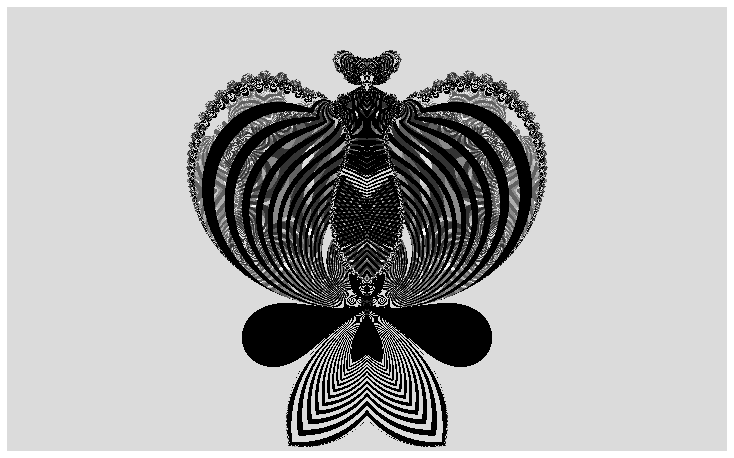

In [4]:
I_32 = primitive_2_gray_float32(ETn)
nb_imshow(I_32)

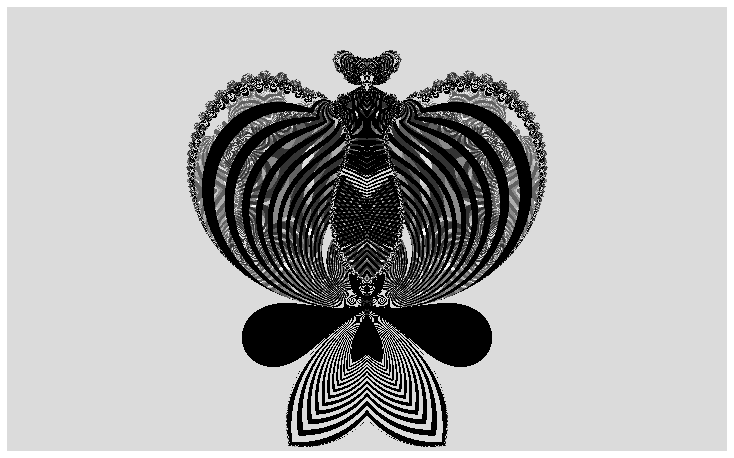

In [5]:
I_16 = primitive_2_gray_16bit(ETn)
nb_imshow(I_16)

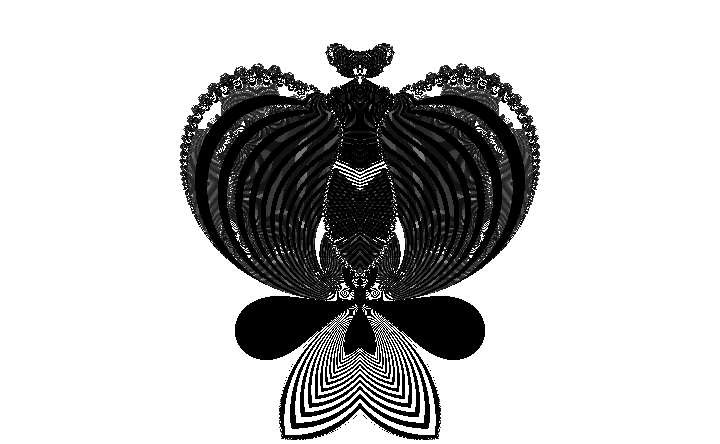

In [6]:
I_8 = primitive_2_gray(ETn)
nb_imshow(I_8)

In [7]:
def hsv_norm(Z0, Z, ET):
    """ V, S, H = hsv_norm(Z0, Z, ET); Graphically usable matrices from escape time algorithm result 
    Args:
        Z0:     matrix of complex starting points
        Z:      matrix of final points (complex)
        ET:     Escape-Time -- number of iterations
        
    Returns:
        V:      value
        S:      saturation
        H:      hue
    """
    Zv = Z - ET
    V = mat2graphic(Zv)
    S = 1 - mat2graphic(np.arctan2(np.imag(Z), np.real(Z)))
    H = mat2graphic(Z - Z0)

    return V, S, H

def get_rgb_32bit_NB(Z0, Z, ET, norm=''):
    """ get a color image from  the products of the escape-time-algorithm Using HSV - RGB model:

    Args:
        ET:     (Integer) matrix of the Escape Times
        Z:      (complex) matrix of the final vectors
        Z0:     (complex) matrix of the starting plane
        norm:   'hsv', 'etg', ''
    Returns:
        RGB:      OpenCV float 32 image

    """
    n_rows = np.shape(ET)[0]
    n_cols = np.shape(ET)[1]
    
    if norm == 'hsv':
        V, S, H = hsv_norm(Z0, Z, ET)
    elif norm == 'etg':
        V, S, H = etg_norm(Z0, Z, ET)
    else:
        V, S, H = etg_norm(ET, Z, Z0)
        
    HSV = np.zeros((n_rows, n_cols, 3)).astype(np.float32)
    HSV[:, :, 0] += H.astype(np.float32) # Hue
    HSV[:, :, 1] += S.astype(np.float32)  # Saturation
    HSV[:, :, 2] += V.astype(np.float32)  # Value

    RGB = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB)

    return RGB

def cv2_rgb_2_gray(rgb_im):
    return cv2.cvtColor(rgb_im, cv2.COLOR_RGB2GRAY)
    
def get_32bit_gray_NB(Z0, Z, ET):
    """ Usage: gray_32_bit = get_32bit_gray(ET, Z, Z0)
    """
    return cv2.cvtColor(get_rgb_32bit_NB(Z0, Z, ET), cv2.COLOR_RGB2GRAY)

In [ ]:
Irgb = get_rgb_32bit_NB(Z0_1, Z_1, ET_1, norm='etg')
nb_imshow(Irgb)
Ig = cv2_rgb_2_gray(Irgb)
n_pxls = (np.array(Ig.shape)).prod()
n_unique = len(set(Ig.reshape(-1)))
print('grayscale matrix:', type(Ig), '\npixels', type(Ig[0,0]), '\n%i possible index values'%(2**32 - 1))
print('grayscale: %i index values in %i pixels'%(n_unique, n_pxls))

nb_imshow(Ig)

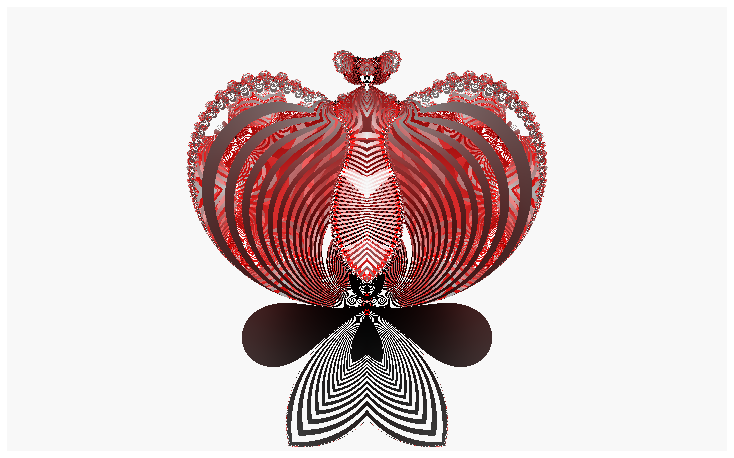

grayscale matrix: <class 'numpy.ndarray'> 
pixels <class 'numpy.float32'> 
4294967295 possible index values
grayscale: 56189 index values in 319680 pixels


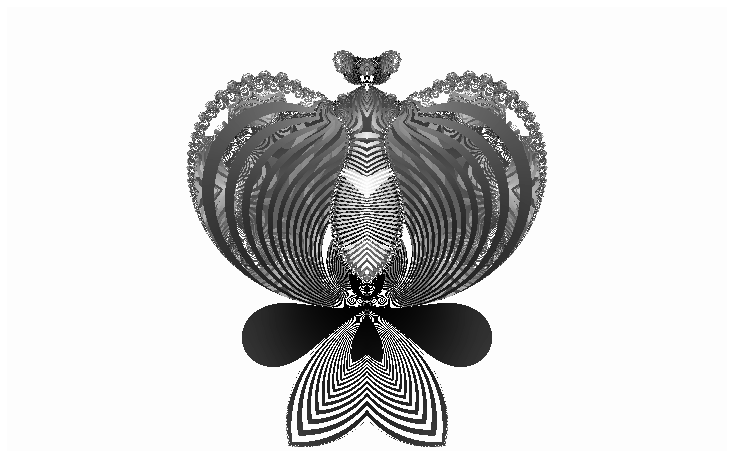

In [8]:
Irgb = get_rgb_32bit_NB(Z0_1, Z_1, ET_1, norm='hsv')
nb_imshow(Irgb)
Ig = cv2_rgb_2_gray(Irgb)
n_pxls = (np.array(Ig.shape)).prod()
n_unique = len(set(Ig.reshape(-1)))
print('grayscale matrix:', type(Ig), '\npixels', type(Ig[0,0]), '\n%i possible index values'%(2**32 - 1))
print('grayscale: %i index values in %i pixels'%(n_unique, n_pxls))


nb_imshow(Ig)

In [ ]:
Irgb = get_rgb_32bit_NB(Z0_1, Z_1, ET_1, norm='bobs_yer_uncle')
nb_imshow(Irgb)
Ig = cv2_rgb_2_gray(Irgb)
n_pxls = (np.array(Ig.shape)).prod()
n_unique = len(set(Ig.reshape(-1)))
print('grayscale matrix:', type(Ig), '\npixels', type(Ig[0,0]), '\n%i possible index values'%(2**32 - 1))
print('grayscale: %i index values in %i pixels'%(n_unique, n_pxls))

nb_imshow(Ig)

In [ ]:
Irgb = get_rgb_32bit_NB(Z0_1, Z_1, ET_1)
nb_imshow(Irgb)
Ig = get_32bit_gray_NB(Z0_1, Z_1, ET_1)
nb_imshow(Ig)

In [ ]:
n_pxls = (np.array(Ig.shape)).prod()
n_unique = len(set(Ig.reshape(-1)))
n_pxls, n_unique, n_pxls - n_unique, type(Ig), type(Ig[0,0])

In [ ]:
# Zd, Zr, ETn = etg_norm(Z0_1, Z_1, ET_1)
uvals = list(set(Ig.reshape(-1)))
Z_flat, n_colors = flat_index(np.abs(Z_1-Z0_1))
Z_flat_norm = graphic_norm(Z_flat)
plt.plot(Z_flat_norm.reshape(-1))
plt.show()

In [ ]:
show_equations()

In [ ]:
# rgb_32_bit = get_rgb_32bit(Z0_1, Z_1, ET_1)
rgb_32_bit = get_rgb_32bit(ET_1, Z_1, Z0_1)
print('32 bit')
nb_imshow(rgb_32_bit)
huh = im_io.imsave('im_io_rgb_32.tif', rgb_32_bit)

# gray_32_bit = get_32bit_gray(Z0_1, Z_1, ET_1)
gray_32_bit = get_32bit_gray(ET_1, Z_1, Z0_1)
print('32 bit gray')
nb_imshow(gray_32_bit)
huh = im_io.imsave('im_io_gray_32.tif', gray_32_bit)


# gray_16_bit = get_16bit_gray(Z0_1, Z_1, ET_1)
gray_16_bit = get_16bit_gray(ET_1, Z_1, Z0_1)
print('16 bit')
nb_imshow(gray_16_bit)
huh = im_io.imsave('im_io_gray_16.tif', gray_16_bit)

### type PIL.Image.Image

In [ ]:
rgb_8_im = get_im(Z0_1, Z_1, ET_1)
print('8 bit rgb PIL')
nb_imshow(rgb_8_im)
huh = rgb_8_im.save('PIL_save.tif')

gray_8_im = get_gray_im(Z0_1, Z_1, ET_1)
print('8 bit gray PIL')
nb_imshow(gray_8_im)
huh = gray_8_im.save('PIL_gray_save.tif')

## mapping
```python
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

cdict = {'red':   [[0.0,  0.0, 0.0],
                   [0.5,  1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [0.25, 0.0, 0.0],
                   [0.75, 1.0, 1.0],
                   [1.0,  1.0, 1.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [0.5,  0.0, 0.0],
                   [1.0,  1.0, 1.0]]}

testCmap = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

#                       get matplotlib Named colormaps:
c_map = matplotlib.cm.get_cmap(c_map_name)
im = c_map(float_arr)
```
### primitives: hue extrated from colo-map, light/shade edges from complex image
    * mapped_arr = map_float_arr(float_mat, cmap):
    * hue_mat = mat_map_to_hue_mat(float_mat, cmap):
    * rgb_arr = hsv_mapped_rgb_im_arr(hue_mat, sat_values, value_values):
    * light_edges, shadow_edges = rgb_edges(float_mat):
    * rgb_accented = rgb_arr_overlay_edges(rgb_arr, edge_arr):


In [ ]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print(flags)

In [ ]:
for f in os.listdir():
    _, fx = os.path.splitext(f)
    if fx == '.tif':
        print(f)

In [ ]:

# im_io.imsave('gray_16_im_skimio.tif', gray_16_im)

In [ ]:
tc0 = time.time()
gray_im = get_gray_im(ET_1, Z_1, Z0_1)
print('%0.3f'%(time.time() - tc0))
type(gray_im), type(np.array(gray_im)[0,0]), gray_im.size

display(gray_im)

In [ ]:
# import skimage.io as im_io
# im_io.imsave('rgb.tif', rgb_im)

In [ ]:
BITS16 = 2**16 - 1
gray_im_16 = (np.array(gray_im) * BITS16).astype(np.uint16)
#                                                 cv2.imwrite('gray_im_16.png', gray_im_16)
nb_imshow(im_arr=gray_im)

In [ ]:
dpi_here = 72
mpl.rcParams['figure.dpi'] = dpi_here
h, w = np.array(gray_im).shape
fig_size = w / dpi_here, h / dpi_here
fig = plt.figure(figsize=fig_size)
ax = fig.add_axes([0,0,1,1])
ax.axis('off')
ax.imshow(gray_im, cmap='gray')
plt.show()

```python
import matplotlib as mpl

def display_image_in_actual_size(im_path):

    dpi = mpl.rcParams['figure.dpi']
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

display_image_in_actual_size("./your_image.jpg")
```

In [ ]:
help(cv2.imshow)

In [ ]:

# gry_im = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

n_rows, n_cols = ET_1.shape

Zd_n2, Zr_n2, ETn_n2 = etg_norm(Z0_1, Z_1, ET_1)


HSV = np.zeros((n_rows, n_cols, 3)).astype(np.float32)
HSV[:,:,0] += ETn_n2.astype(np.float32)     # Hue
HSV[:,:,1] += Zr_n2.astype(np.float32)      # Saturation
HSV[:,:,2] += Zd_n2.astype(np.float32)      # Value

RGB = np.zeros((n_rows, n_cols, 3)).astype(np.float32)

RGB = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB)
#HSV cv2.cvtColor(RGB, cv2.COLOR_RGB2HSV)
G = cv2.cvtColor(RGB, cv2.COLOR_RGB2GRAY)
G.shape, type(G[0,0])

## Operations with cv2 images

In [ ]:
BITS16 = 2**16 - 1
G16 = (G * BITS16).astype(np.uint16)
plt.imshow(G16, 'gist_yarg')

In [ ]:
n = 1
Z = im_to_Z(G16, n)

#                   complex_mat_to_im(Z) == 16 bit && skip PIL
Zd = np.abs(Z)
Zr = np.arctan2(np.real(Z), np.imag(Z))

BITS16 = 2**16 - 1
img = (mat2graphic(np.maximum(graphic_norm(Zr), graphic_norm(Zd))) * BITS16).astype(np.uint16)

Zd_16 = ((1-Zd_n2) * BITS16).astype(np.uint16)
# plt.imshow(img, 'gist_gray')
plt.imshow(Zd_16, 'gist_gray')

In [ ]:
n = 1
Z = im_to_Z(G16, n)
img_8 = complex_mat_to_im(Z)

plt.imshow(img, 'gist_gray')

In [ ]:
"""
                    8 bit dakine: PIL
"""
im = get_im(ET_1, Z_1, Z0_1)
im_gray = im.convert('L')
im_gray_array = np.array(im_gray)

Z = im_to_Z(im_gray_array, n)
im_inv = ImageOps.invert(complex_mat_to_im(Z))
display(im_inv)

### Speculation: layered image 
#### ET "edges" channel offers enhancement - segmented crispness
```python
"""
    scalygraphic code to PIL
"""
ET_g = primitive_2_gray(ETn_n2)
im_gray = ET_g.convert('L')
im_gray_array = np.array(im_gray)

Z = im_to_Z(im_gray_array, n)
im_inv = ImageOps.invert(complex_mat_to_im(Z))
```
####  ET "hues" channel fills segments
```python
"""
    color-map with matplotlib
"""
c_map_name = 'Set1'
c_map = mpl.cm.get_cmap(c_map_name)
im = c_map(ETn_n2)
```
#### "saturation" conveys dist & rotation
```python
"""
    back to 8 bit for transform with PIL
"""
im = np.uint8(im * 255)
im = tip.Image.fromarray(im)
HSV = im.convert('HSV')
```

In [ ]:
# ET "edges" channel offers enhancement - segmented crispness
#                                                                ET_g = primitive_2_gray(ETn_n2)
# ET_g = get_32bit_gray(ET_1, Z_1, Z0_1)
ET_g = mat2graphic(ET_1)
# im_gray = ET_g.convert('L')
# im_gray_array = np.array(im_gray)

Z = im_to_Z(ET_g, n)
im_inv = ImageOps.invert(complex_mat_to_im(Z))
display(im_inv)

## color-map index from both ET + Zd:


In [ ]:
# Zd = mat2graphic(np.abs(Z0_1 - Z_1))
Zd_n2, Zr_n2, ETn_n2 = etg_norm(Z0_1, Z_1, ET_1)
cmp_idx = mat2graphic(ET_1 + Zd_n2)

In [ ]:
#  ET "hues" channel fills segments
Zd_n2, Zr_n2, ETn_n2 = etg_norm(Z0_1, Z_1, ET_1)
# cmp_idx = mat2graphic(ET_1 + Zd_n2)
cmp_idx = mat2graphic(ET_1 + Zr_n2 * Zd_n2)

c_map_name = 'RdYlGn'
c_map = mpl.cm.get_cmap(c_map_name)

im = c_map(cmp_idx)
# im = c_map(ET_1 + Zd_n2)
im = np.uint8(im * 255)
im = tip.Image.fromarray(im)

display(im)

In [ ]:
"""
                    Experimentation cell: dynamic controls needed here
"""
c_map_name = 'RdYlGn'
c_map = mpl.cm.get_cmap(c_map_name)
# cmp_idx = mat2graphic(ET_1 + Zr_n2 * Zd_n2)
# im = c_map(cmp_idx)
# im = c_map(ET_1 * Zd_n2 + Zr_n2)
# im = c_map(ETn_n2)
im = c_map(ET_1 + Zd_n2)
im = np.uint8(im * 255)
im = tip.Image.fromarray(im)

# im_inv = ImageOps.invert(complex_mat_to_im(Z))
im_arr = np.array(im_inv)
brite_edges = np.array(complex_mat_to_im(Z))
print(type(im), im.size, im.mode)
HSV = np.array(im.convert('HSV'))
HSV.shape, im_arr.shape, Zr_n2.shape

In [ ]:
rgb_im = np.zeros((im.size[1]-1, im.size[0]-1, 3)).astype(np.uint8)
rgb_im[:,:,0] += HSV[:-1,:-1, 0]
rgb_im[:,:,1] += ((0.3 * (1-Zr_n2[:-1,:-1]) + 0.05) * 255).astype(np.uint8)
rgb_im[:,:,2] += im_arr // 2 + 128
#rgb_im[:,:,2] += brite_edges // 4 + 196
I = tip.Image.fromarray(rgb_im, 'HSV').convert('RGB')

display(I)

## Prototype ^ toward a more natural color mapping
## (Need to deal with *im_2_Z* padding issue)

In [ ]:
show_color_maps()

In [ ]:

Zd_n2, Zr_n2, ETn_n2 = etg_norm(Z0_1, Z_1, ET_1)
Zd_n2.shape

In [ ]:
np.array(im_inv).shape

## Earlier Speculations Below:

In [ ]:
c_map_name = 'Set3'

Zd_16 = (Zd_n2 * BITS16).astype(np.uint16)
c_map = mpl.cm.get_cmap(c_map_name)
im = c_map(Zd_n2)

im = np.uint8(im * 255)
im = tip.Image.fromarray(im)
display(im)

In [ ]:
c_map_name = 'Greens'

# Zd_16 = (Zd_n2 * BITS16).astype(np.uint16)
c_map = mpl.cm.get_cmap(c_map_name)
im = c_map(Zd_n2)

plt.imshow(im)

In [ ]:
show_color_maps()

## Test save and open with scikit-image io (it works to preserve 16 bit)

In [ ]:
dir(cv2)

## Useful examples -- *impute_color.py* functions
****
### View the raw escape time & distance data in greyscle:
* Note that most of the data is not easy to see because the extremes hog the black or white.
* Enumerated, normalized version below shows all three imputed with an HSV scheme.
### Naive method: no normalization

In [ ]:
# g_im_et = primitive_2_gray(ET_1)
# g_im_Zd = primitive_2_gray(np.abs(Z_1 - Z0_1))
# Zv = Z_1 - Z0_1
# Zv = np.arctan2(np.imag(Zv), np.real(Zv))
# g_im_Zr = primitive_2_gray(Zv)


# im_list = [g_im_et,g_im_Zd,g_im_Zr]
# new_im = cat_im_list_hori(im_list)

# print('%15s%30s%30s'%('ET','Zd','Zr'))
# display(new_im)

### Naive method: normalize all to graphic floats in range (0, 1)

In [ ]:
# # complex result vectors == final minus initial
# Z_vec = Z_1 - Z0_1

# #                             normaize all to (0, 1)
# # number of iterations
# ET_n1 = graphic_norm(ET_1)
# g_im_et = primitive_2_gray(ET_n1)
# # complex result vectors: distance component
# Zd_n1 = np.abs(Z_vec)
# Zd_n1 = graphic_norm(Zd_n1)
# g_im_Zd = primitive_2_gray(Zd_n1)

# # complex result vectors: rotation component
# Zr_n1 = np.arctan2(np.imag(Z_vec), np.real(Z_vec))
# Zr_n1 = graphic_norm(Zr_n1)
# g_im_Zr = primitive_2_gray(Zr_n1)

# n_rows = np.shape(ET_1)[0]
# n_cols = np.shape(ET_1)[1]

# im_list = [g_im_et,g_im_Zd,g_im_Zr]
# new_im = cat_im_list_hori(im_list)

# print('%15s%30s%30s'%('ET','Zd','Zr'))
# display(new_im)

### Problems with the Naive method:
    * Extremes pixel values mask the details in the softer regions


In [ ]:
# Zd_n2, Zr_n2, ETn_n2 = etg_norm(Z0_1, Z_1, ET_1)

# g_im_et = primitive_2_gray(ETn_n2)
# # complex result vectors: distance component
# g_im_Zd = primitive_2_gray(Zd_n2)

# # complex result vectors: rotation component
# g_im_Zr = primitive_2_gray(Zr_n2)

# im_list = [g_im_et,g_im_Zd,g_im_Zr]
# new_im = cat_im_list_hori(im_list)

# print('%15s%30s%30s'%('ET','Zd','Zr'))
# display(new_im)

### Much better visibility for the distance channel 


### Compositing all three makes a smooter image

In [ ]:
im_gray = get_gray_im(ET_1, Z_1, Z0_1)
display(im_gray)

In [ ]:
gray_array = np.array(im_gray)

g = gray_array.reshape(-1)
len(list(set(g)))

In [ ]:
# Zv = Z_1 - Z0_1

# ET_f, n_colors = flat_index(ET_1)
# g_im_et = primitive_2_gray(ET_f)

# Zv_f, n_colors = flat_index(np.abs(Zv))
# g_im_Zd = primitive_2_gray(Zv_f)


# Zr = np.arctan2(np.imag(Zv), np.real(Zv))
# Zr_f, n_colors = flat_index(Zr)
# g_im_Zr = primitive_2_gray(Zr_f)


# im_list = [g_im_et,g_im_Zd,g_im_Zr]
# new_im = cat_im_list_hori(im_list)

# print('%15s%30s%30s'%('ET','Zd','Zr'))
# display(new_im)

## Compare normalization options for grayscale from HSV>RGB
Note that the raw normaization has less detail in the gradients

In [ ]:
# im = map_raw_etg(Z0_1, Z_1, ET_1, c_map_name='gist_gray')
# display(im)

In [ ]:
im = get_gray_im(ET_1, Z_1, Z0_1)
A = np.array(im)
print('A.shape, A[0,0], type(A[0,0])\n',A.shape, A[0,0], type(A[0,0]))
display(im)

In [ ]:
# g_im_et = primitive_2_gray(ET_1)
# display(g_im_et)

In [ ]:
# g_im_Zd = primitive_2_gray(np.abs(Z_1 - Z0_1))
# display(g_im_Zd)

In [ ]:
# Zd_1, Zr_1, ETn_1 = etg_norm(Z0_1, Z_1, ET_1)
# Zv = Z_1 - Z0_1
# Zv = np.arctan2(np.imag(Zv), np.real(Zv))
# g_im_Zr = primitive_2_gray(Zv)
# # g_im = tip.Image.fromarray(Zv, 'L', colors=2**16-1)

# display(g_im_Zr)

### View all results as an HSV (converted to RGB for display)
```python
# normalized enumeration of Z-Z0 distance, rotation (Zd, Zr) and Escape Time
Zd, Zr, ETn = etg_norm(Z0, Z, ET)

A = np.zeros((n_rows, n_cols,3))
A[:,:,0] += ETn     # Hue
A[:,:,1] += Zr      # Saturation
A[:,:,2] += Zd      # Value
```

## View The Rotated Data with different color assignments

In [ ]:
def map_etg_composite_NB(Z0, Z, ET, c_map_name='gray'):
    """ get an RGB image of HSV composite index to color map

    Args:
        ET:     (Integer) matrix of the Escape Times
        Z:      (complex) matrix of the final vectors
        Z0:     (complex) matrix of the starting plane

    Returns:
        I:      RGB PIL image
    """
    im = np.array(get_im(ET, Z, Z0).convert('L'))

    c_map = mpl.cm.get_cmap(c_map_name)
    im = c_map(im)
    
    im = np.uint8(im * 255)
    # im = np.uint16(im * 65535)
    im = tip.Image.fromarray(im)
    
    return im

im_test = map_etg_composite_NB(Z0_1, Z_1, ET_1, c_map_name='gray')
display(im_test)

In [ ]:
#                     HSV to RGB composite
im = get_im(ET_1, Z_1, Z0_1)
display(im)

## Color map assignment to where greyscale is used as index to map
(choose color map from the list)

In [ ]:
show_color_maps(6)

In [ ]:
#                     HSV to RGB composite to Greyscale as index to colormap
do_im = map_etg_composite_NB(Z0_1, Z_1, ET_1, c_map_name='afmhot')
display(do_im)

In [ ]:
do_im = map_etg_composite_NB(Z0_1, Z_1, ET_1, c_map_name='gray')
A = np.array(do_im)
print('A.shape, A[0,0], type(A[0,0])\n',A.shape, A[0,0], type(A[0,0]))

display(do_im)

In [ ]:
do_im = map_etg_composite_NB(Z0_1, Z_1, ET_1, c_map_name='nipy_spectral')
display(do_im)

In [ ]:
do_im = map_etg_composite_NB(Z0_1, Z_1, ET_1, c_map_name='jet')
display(do_im)

```text
Help on built-in function imwrite:

imwrite(...)
    imwrite(filename, img[, params]) -> retval
    .   @brief Saves an image to a specified file.
    .   
    .   The function imwrite saves the image to the specified file. The image format is chosen based on the
    .   filename extension (see cv::imread for the list of extensions). In general, only 8-bit
    .   single-channel or 3-channel (with 'BGR' channel order) images
    .   can be saved using this function, with these exceptions:
    .   
    .   - 16-bit unsigned (CV_16U) images can be saved in the case of PNG, JPEG 2000, and TIFF formats
    .   - 32-bit float (CV_32F) images can be saved in PFM, TIFF, OpenEXR, and Radiance HDR formats;
    .   3-channel (CV_32FC3) TIFF images will be saved using the LogLuv high dynamic range encoding
    .   (4 bytes per pixel)
    .   - PNG images with an alpha channel can be saved using this function. To do this, create
    .   8-bit (or 16-bit) 4-channel image BGRA, where the alpha channel goes last. Fully transparent pixels
    .   should have alpha set to 0, fully opaque pixels should have alpha set to 255/65535 (see the code sample below).
    .   
    .   If the format, depth or channel order is different, use
    .   Mat::convertTo and cv::cvtColor to convert it before saving. Or, use the universal FileStorage I/O
    .   functions to save the image to XML or YAML format.
    .   
    .   The sample below shows how to create a BGRA image and save it to a PNG file. It also demonstrates how to set custom
    .   compression parameters:
    .   @include snippets/imgcodecs_imwrite.cpp
    .   @param filename Name of the file.
    .   @param img Image to be saved.
    .   @param params Format-specific parameters encoded as pairs (paramId_1, paramValue_1, paramId_2, paramValue_2, ... .) see cv::ImwriteFlags
```